In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy
import matplotlib.pyplot as plt
from astropy import units
from scipy.integrate import cumtrapz

# Optional:
from astropy.visualization import quantity_support

#### Generating input
* extinction ($\alpha_\nu$)
* depth ($l$) and height ($z$) scale
* source function $S_\nu$

In [2]:
freq = numpy.linspace(-5, 5, 101)
extinction = (numpy.exp(-freq ** 2) + 0.5 * freq / 50 + 0.1) / units.m / 100

depth = numpy.logspace(0, 4, 200) * units.km
height = -depth + depth.max()

i_units = units.Quantity(1, unit='kW m^-2 Hz^-1 sr^-1')
source_function = (depth.value) / 100 * i_units  # assume S is frequency-independent
source_function = numpy.linspace(0, 500, len(depth)) * i_units
source_function = numpy.exp(-depth.value / 500) * i_units

# Make extinction the same at all depths (unrealistic)
extinction = numpy.tile(extinction, (len(depth), 1))

## Calculations

### Optical depth
$$
\tau_\nu (z_0) = -\int_\infty^{z_0} \alpha_\nu \mathrm{d}z \;\;\;\; \mathrm{(height\; scale)}
$$

$$
\tau_\nu (l_0) = \int_0^{l_0} \alpha_\nu \mathrm{d}l\;\;\;\; \mathrm{(depth\; scale)}
$$

Note that $z=\infty$ is the same point as $l=0$, and corresponds to the surface of the emitting body (here assumed to have an infinite extent). The $\tau$ integration can be done both ways.

### Emerging intensity

$$
I_\nu(\tau_\nu=0) = \int_0^\infty S_\nu e^{-\tau_\nu}\mathrm{d}\tau_\nu.
$$

In [3]:
tau = cumtrapz(extinction, -height, axis=0, initial=1e-3) # integrating tau
intensity = numpy.trapz(
    source_function[:, numpy.newaxis] * numpy.exp(-tau),
    tau,
    axis=0
)

### Plotting

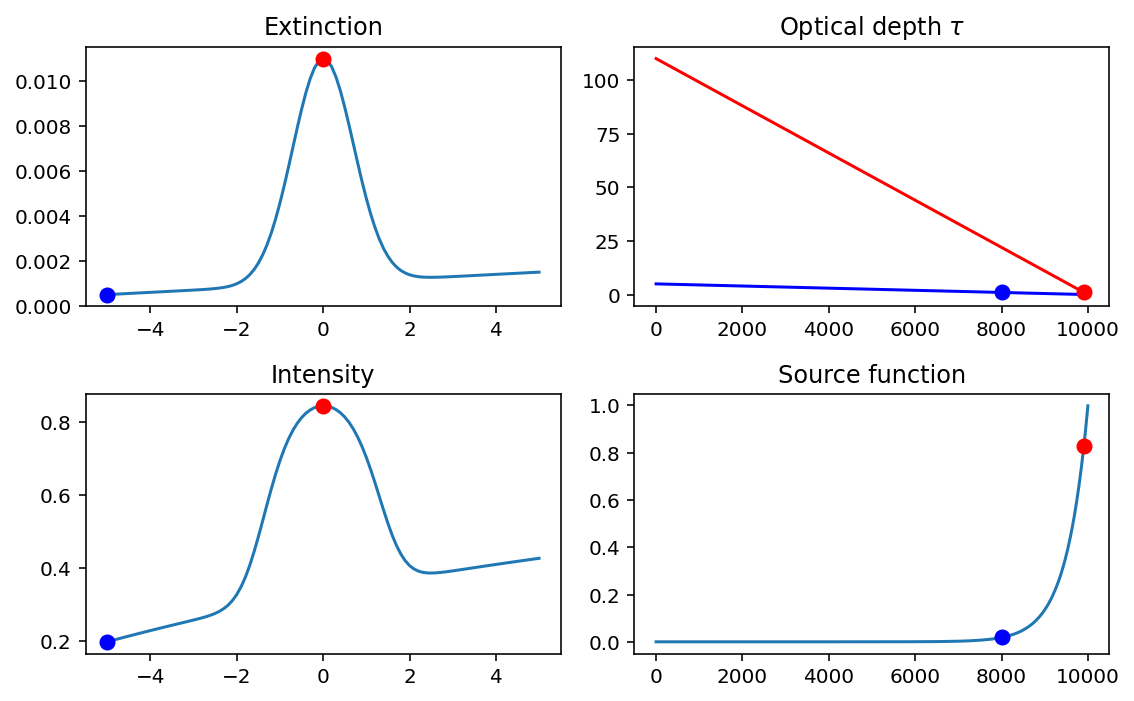

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0,0].plot(freq, extinction[0])
ax[0,0].plot([freq[0]], [extinction[0,0].value], 'bo', ms=7)
ax[0,0].plot([freq[50]], [extinction[0,50].value], 'ro', ms=7)
ax[0,0].set_title("Extinction")

ax[0,1].plot(height, tau[:, 0], 'b-')
ax[0,1].plot(height, tau[:, 50], 'r-')
tau1_0 = numpy.argmin(numpy.abs(tau[:, 0] - 1.)) # Height where tau=1
tau1_50 = numpy.argmin(numpy.abs(tau[:, 50] - 1.))
ax[0,1].plot([height[tau1_0].value], 1, 'bo', ms=7)
ax[0,1].plot([height[tau1_50].value], 1, 'ro', ms=7)
ax[0,1].set_title(r"Optical depth $\tau$")

ax[1,1].plot(height, source_function)
ax[1,1].plot(height[tau1_0], source_function[tau1_0], 'bo', ms=7)
ax[1,1].plot(height[tau1_50], source_function[tau1_50], 'ro', ms=7)
ax[1,1].set_title("Source function")

ax[1,0].plot(freq, intensity)
ax[1,0].plot(freq[0], intensity[0], 'bo', ms=7)
ax[1,0].plot(freq[50], intensity[50], 'ro', ms=7)
ax[1,0].set_title("Intensity")
plt.tight_layout();